# Garbage Classification Using MobileNetV2

## Data Loading

In [ ]:
!kaggle datasets download -d asdasdasasdas/garbage-classification

Dataset URL: https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification
License(s): copyright-authors
 76% 62.0M/82.0M [00:00<00:00, 219MB/s]
100% 82.0M/82.0M [00:00<00:00, 211MB/s]


In [ ]:
!kaggle datasets download -d mostafaabla/garbage-classification

Dataset URL: https://www.kaggle.com/datasets/mostafaabla/garbage-classification
License(s): ODbL-1.0
 90% 214M/239M [00:01<00:00, 218MB/s]
100% 239M/239M [00:01<00:00, 216MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/garbage-classification1.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

zip_ref = zipfile.ZipFile('/content/garbage-classification2.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

## Data Preparation

In [ ]:
# Importing Necessory Libraries

import os
import time
import shutil
import pathlib
import itertools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

import warnings
warnings.filterwarnings("ignore")

In [ ]:
dataset = ['/content/Garbage classification/Garbage classification' ,
              '/content/garbage_classification']

In [ ]:
selectedClasses = ['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic' ,'white-glass']

In [ ]:
# Creating Dataframe

def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


In [ ]:
df = df.sample(frac=1).reset_index(drop=True)
df.head(5)

,imgPath,label
0,/content/garbage_classification/white-glass/wh...,glass
1,/content/garbage_classification/paper/paper554...,paper
2,/content/Garbage classification/Garbage classi...,cardboard
3,/content/Garbage classification/Garbage classi...,cardboard
4,/content/Garbage classification/Garbage classi...,paper


## Exploratory Data Analysis

In [ ]:
df.shape

(7574, 2)

In [ ]:
df.size

15148

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7574 entries, 0 to 7573
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   imgPath  7574 non-null   object
 1   label    7574 non-null   object
dtypes: object(2)
memory usage: 118.5+ KB


In [ ]:
df.describe().T

,count,unique,top,freq
imgPath,7574,7574,/content/garbage_classification/white-glass/wh...,1
label,7574,6,paper,1644


In [ ]:
df.nunique()

,0
imgPath,7574
label,6


In [ ]:
df.isnull().sum()

,0
imgPath,0
label,0


In [ ]:
df.duplicated().sum()

0

In [ ]:
unique_label = df['label'].unique()
print(unique_label)

['glass' 'paper' 'cardboard' 'plastic' 'trash' 'metal']


In [ ]:
df['label'].value_counts()

,count
label,
paper,1644
plastic,1347
cardboard,1294
glass,1276
metal,1179
trash,834


## Data Preprocessing

In [ ]:
# Train Test and split

def DataFrameSpliting(df , ratio , classesList):

    trainDf = pd.DataFrame(columns = ['imgPath','label'])
    testDf = pd.DataFrame(columns = ['imgPath','label'])
    for clas in classesList :
        tempDf = df[df['label'] == clas]
        lastIndex = int(len(tempDf) * ratio)
        trainClassDf = tempDf[:lastIndex]
        testClassDf = tempDf[lastIndex:]
        trainDf = pd.concat([trainDf , trainClassDf] , axis=0)
        testDf = pd.concat([testDf , testClassDf] , axis=0)

    return trainDf.sample(frac=1).reset_index(drop=True) , testDf.sample(frac=1).reset_index(drop=True)  # shuffling , reset index

In [ ]:
classList = list(df['label'].unique())
trainDf , testDf = DataFrameSpliting(df , 0.85 , classList)

In [ ]:
trainDf.head(5)

,imgPath,label
0,/content/Garbage classification/Garbage classi...,paper
1,/content/garbage_classification/trash/trash13.jpg,trash
2,/content/garbage_classification/white-glass/wh...,glass
3,/content/garbage_classification/cardboard/card...,cardboard
4,/content/garbage_classification/cardboard/card...,cardboard


In [ ]:
testDf.head(5)

,imgPath,label
0,/content/Garbage classification/Garbage classi...,plastic
1,/content/Garbage classification/Garbage classi...,plastic
2,/content/garbage_classification/cardboard/card...,cardboard
3,/content/garbage_classification/white-glass/wh...,glass
4,/content/garbage_classification/plastic/plasti...,plastic


In [ ]:
print('Train dataset shape', trainDf.shape)
print('Test dataset shape', testDf.shape)

Train dataset shape (6434, 2)
Test dataset shape (1140, 2)


In [ ]:
trainDf['label'].value_counts()

,count
label,
paper,1397
plastic,1144
cardboard,1099
glass,1084
metal,1002
trash,708


In [ ]:
testDf['label'].value_counts()

,count
label,
paper,247
plastic,203
cardboard,195
glass,192
metal,177
trash,126


In [ ]:
# Data Augmentation

datagenTrain = ImageDataGenerator(
            rescale=1./255,
            zoom_range=(1.0, 1.2),
            horizontal_flip=True,
            vertical_flip=True,
            rotation_range=45,
)

IMG_SIZE = (224,224)

trainGenerator = datagenTrain.flow_from_dataframe(
    trainDf ,
    x_col='imgPath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=64 ,
    class_mode='categorical'
)


datagenTest = ImageDataGenerator( rescale=1./255 )

testGenerator = datagenTest.flow_from_dataframe(
    testDf ,
    x_col='imgPath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=8 ,
    class_mode='categorical',
    shuffle=False
)

Found 6434 validated image filenames belonging to 6 classes.
Found 1140 validated image filenames belonging to 6 classes.


## Data Visualization

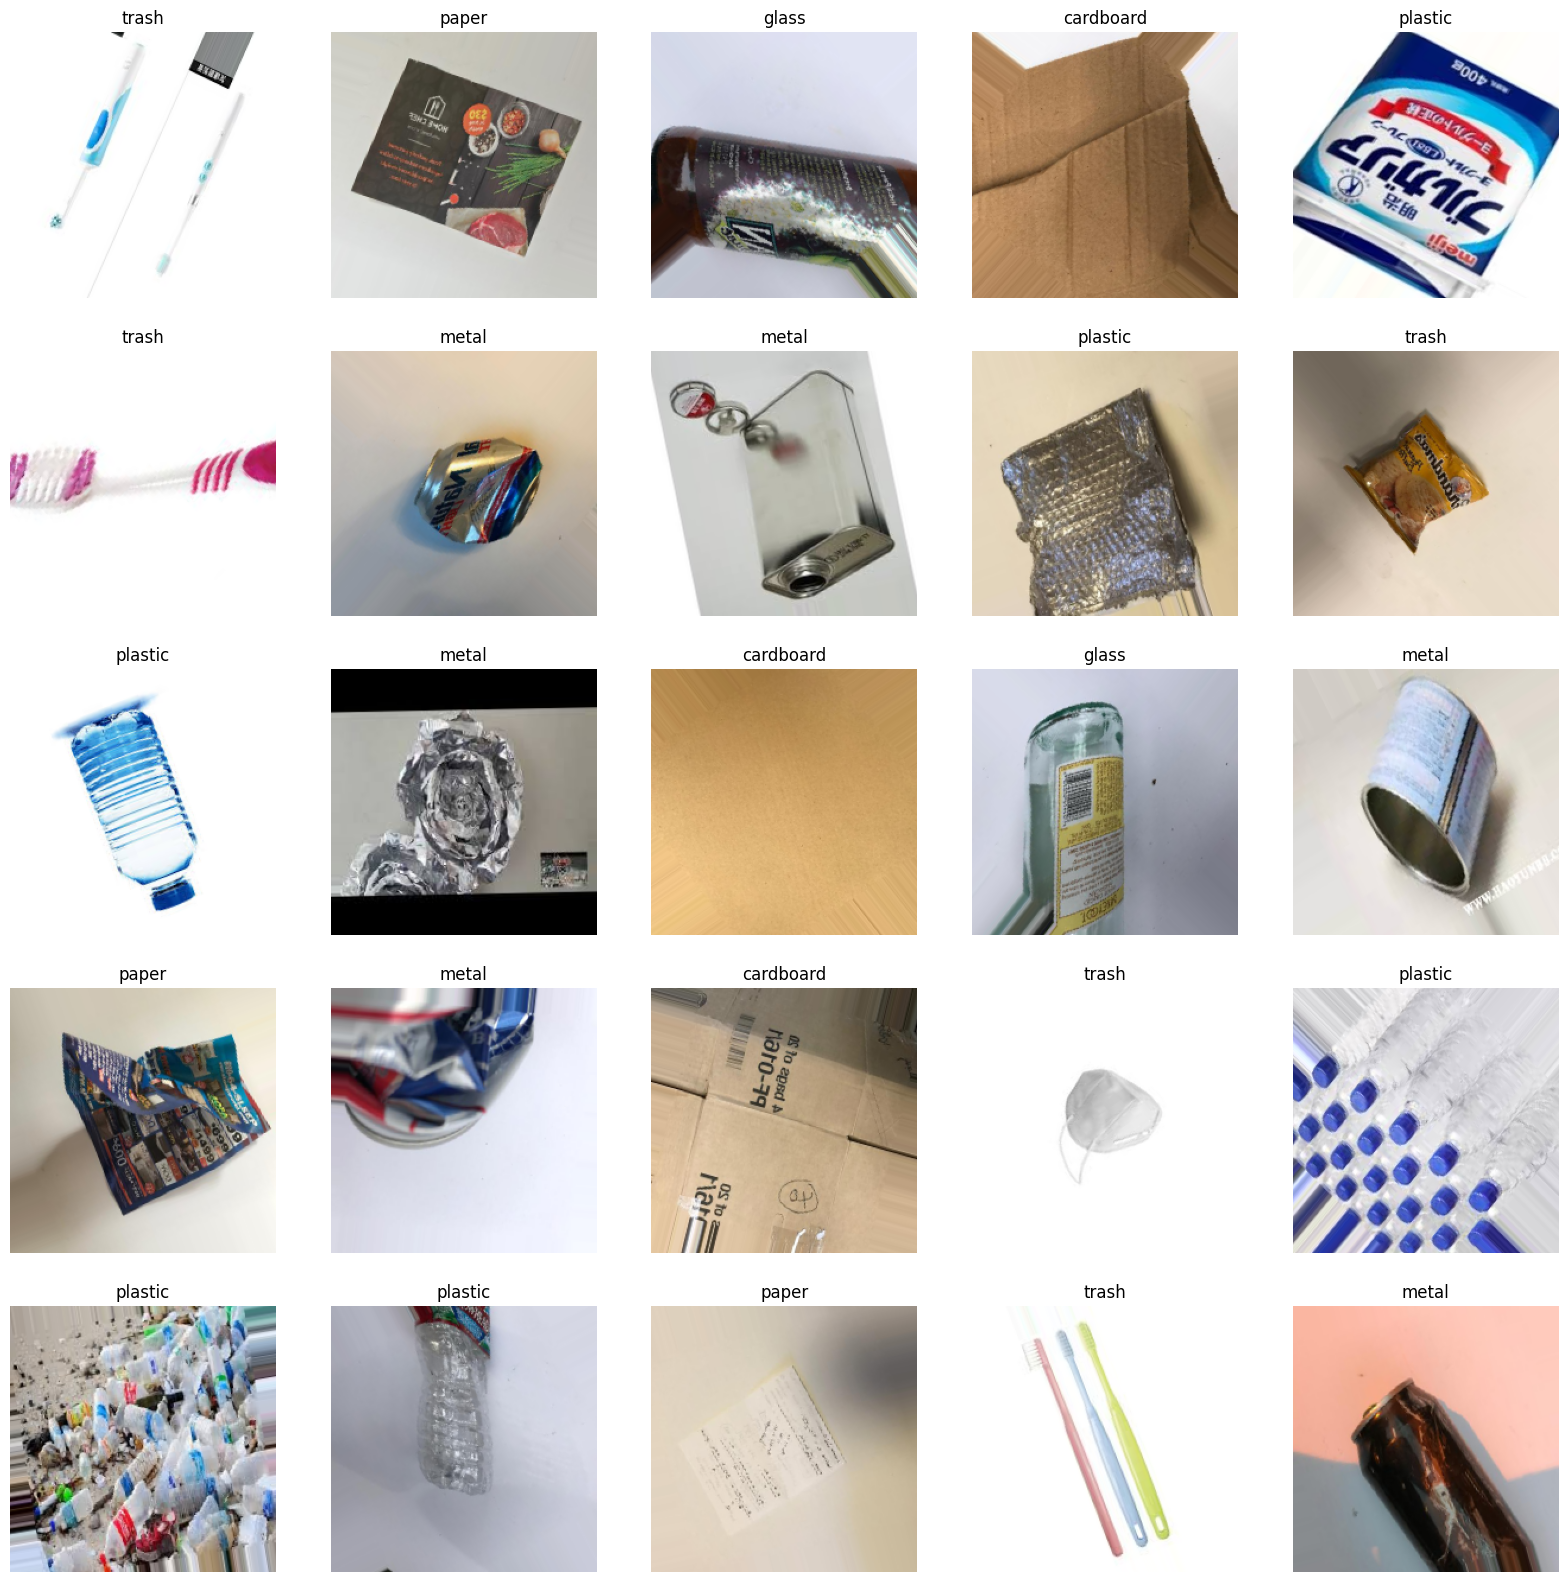

In [ ]:
def show_images(gen):
    g_dict = gen.class_indices
    classes = list(g_dict.keys())
    images, labels = next(gen)
    length = len(labels)
    sample = min(length, 25)

    plt.figure(figsize=(20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)

        image = images[i]
        if image.shape[-1] == 1:
            plt.imshow(image.squeeze(), cmap='gray')
        else:
            plt.imshow(image)

        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='black', fontsize=12)
        plt.axis('off')

    plt.show()

show_images(trainGenerator)

## Model Building

In [ ]:
preTrainedModel = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in preTrainedModel.layers[:-4]:
    layer.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model = Sequential([

    preTrainedModel,
    Flatten(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.08),
    Dense(6, activation='softmax')

])

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy' ,metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │       4,014,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,272,774 (23.93 MB)

 Trainable params: 4,427,462 (16.89 MB)

 Non-trainable params: 1,845,312 (7.04 MB)

In [ ]:
history = model.fit(trainGenerator,
                    validation_data = testGenerator,
                    epochs=20,
)

## Model Prediction

In [ ]:
history_df=pd.DataFrame(history.history)
history_df

In [ ]:
plt.figure(figsize=(15,5))

# plotting accuracy and val_accuracy
plt.subplot(1,2,1)
plt.plot(history_df['accuracy'],label='accuracy',c='red')
plt.plot(history_df['val_accuracy'],label='val_accuracy')
plt.xlabel('epochs')
plt.ylabel('acc value')
plt.title('accuracy VS val_accuracy')
plt.legend()

# plotting loss and val_loss
plt.subplot(1,2,2)
plt.plot(history_df['loss'],label='loss',c='red')
plt.plot(history_df['val_loss'],label='val_loss')
plt.title('loss VS val_loss')
plt.xlabel('epochs')
plt.ylabel('loss value')
plt.legend()

plt.show()